In [12]:
import numpy as np
import glob
from scipy.optimize import curve_fit
import h5py
import ipywidgets
from scipy.stats import chisquare
from natsort import natsorted
from scipy.signal import find_peaks, find_peaks_cwt
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import OrderedDict
from datetime import datetime
import latex
#mpl.rcParams.update(mpl.rcParamsDefault)
print(sys.path)

['../../WaveformAnalysis', '/Library/TeX/texbin/', '../../', '/Users/tizi/Documents/YALE_WL.nosync/purity-monitor/Jupyter/Log', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python310.zip', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/lib-dynload', '', '/Users/tizi/Library/Python/3.10/lib/python/site-packages', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages']


In [13]:
!pwd

/Users/tizi/Documents/YALE_WL.nosync/purity-monitor/Jupyter/Log


In [14]:
import sys
sys.path.insert(0,'../../')
sys.path.insert(0,'/Library/TeX/texbin/')
sys.path.insert(0,'../../WaveformAnalysis')

In [15]:
#plt.style.use('../../style.mplstyle')
#colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

ANSI_RESET = '\u001b[0m'
ANSI_GREEN = '\u001b[32m'
ANSI_CYAN = '\u001b[36m'
ANSI_RED = '\u001b[31m'
ANSI_YELLOW = '\u001b[33m'

In [16]:
import Dataset as Dataset
import Waveform as Waveform
import SiPM as SiPM

In [17]:
import importlib
importlib.reload(Dataset)
importlib.reload(SiPM)
importlib.reload(Waveform)

<module 'Waveform' from '/Users/tizi/Documents/YALE_WL.nosync/purity-monitor/Jupyter/Log/../../WaveformAnalysis/Waveform.py'>

In [18]:
Path = r'/Users/tizi/Documents/YALE_WL.nosync/data/202206*/'

Let's get the voltage steps from the filenames

In [19]:
voltages = glob.glob(Path+'wave*')
voltages = [x.split('_')[-2] for x in voltages]
voltages = np.array(sorted([x.split('OV')[0] for x in voltages]))
voltages = np.unique(voltages)
print(voltages)

['2.00' '2.50' '3.00' '3.50' '4.00' '4.50' '5.00' '5.50' '6.00' '6.50'
 '7.00']


Now we can loop over all files for the various voltages, save the data and run a simple analysis including baseline subtraction and maximum finding

In [20]:
print(sys.path)
def line_gain(x,m,c):
    return (m*x)+c

def gauss(x,a,mu,sigma):
    return (a*np.exp(-0.5*((x-mu)/sigma)**2))

['../../WaveformAnalysis', '/Library/TeX/texbin/', '../../', '../../WaveformAnalysis', '/Library/TeX/texbin/', '../../', '/Users/tizi/Documents/YALE_WL.nosync/purity-monitor/Jupyter/Log', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python310.zip', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/lib-dynload', '', '/Users/tizi/Library/Python/3.10/lib/python/site-packages', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages']


2048
1340


" lower = 0\nupper = 1000\n\ndef baseline(p1, p2):\n    s_mean = np.mean(p1[0:50])\n    a_mean = np.mean(p2[0:50])\n    diff = s_mean-a_mean\n    return (p1-diff, p2+diff)\n\n\ntrash, averaged = baseline(sample,averaged)\n#plt.plot(Ds[volt].Ch[0].Time,averaged,color='royalblue',label='baseline',alpha=0.6)\ncut = sample\na_cut = averaged "

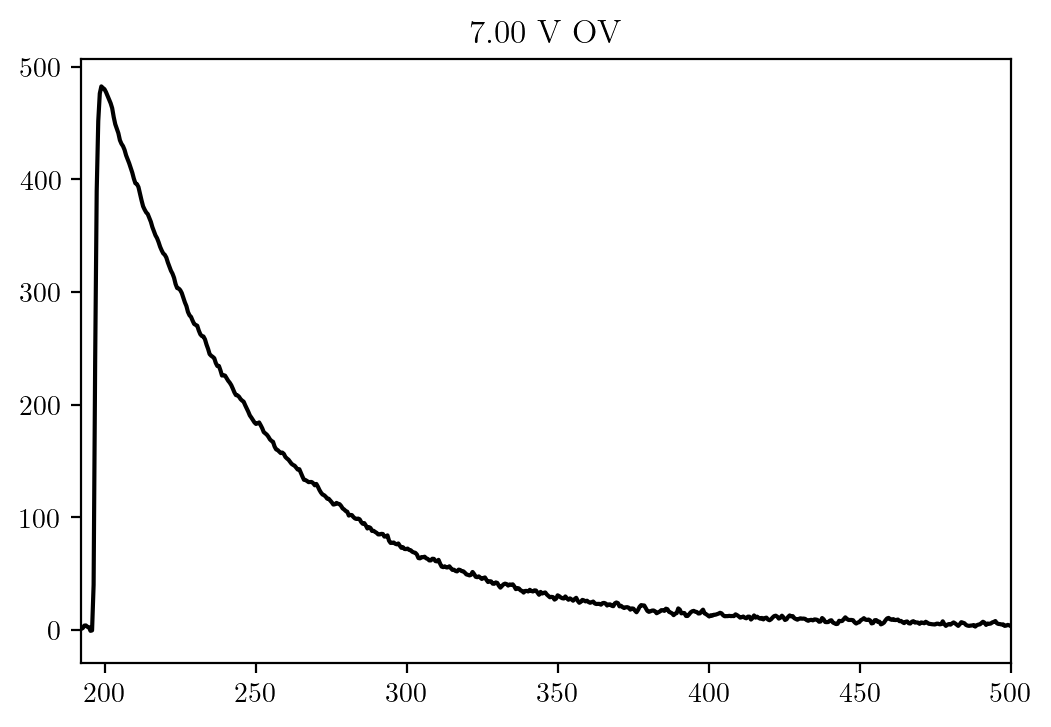

In [21]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
mpl.rcParams['figure.dpi']= 200

Ds = {}
N_peaks= 4
v_data = {}
averaged = np.array([])
sample = []
time = None
samples = []
for volt in voltages[-1:]: 
    Ds[volt] = SiPM.SiPM(Path=Path, Selection='wavefms_keith_{}OV*.h5'.format(volt))
    Ds[volt].Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]
    
    peak_amps = {} #dict of shaping time as key and peak values for waveforms filtered with that shaping time
    peak_occs = {} #same thing but counting the occurrences so it will be a dict of dicts for each shaping time and peak
    all_v = []

    total = 0
    files = 0

    #The code below just loads the data from the files into the SiPM instance Ds[volt]
    for File in natsorted(Ds[volt].Files):
        # print(f'{total} waveforms in total (unfiltered) from {files} files')
        max_amp_all_st=[]
        files += 1
        Ds[volt].ImportDataFromHDF5(File, Ds[volt].Ch, var=[])
        Ds[volt].Ch[0].SubtractBaseline(Data=Ds[volt].Ch[0].Amp, cutoff=150)
        #print(wvf[:10])
        Ds[volt].get_sampling()
        # Ds[volt].shaping_time=[2e-6,5e-6,10e-6] #List of shaping times to shape the signal with
        # Ds[volt].shaping_time=[2e-6] #List of shaping times to shape the signal with
        # Ds[volt].setup_butter_filter() # calculate the butterworth filter coefficients

    time = [0]*len(Ds[volt].Ch[0].Time)
    print(len(time))
    counter = 0
    maxes = []
    sw = True
    for waveform in Ds[volt].Ch[0].Amp: #loop over the waveforms inside the file
    # print(waveform)
        total += 1
        #plt.plot(Ds[volt].Ch[0].Time,waveform,color='black',label='sample data')
        if total % 2 == 0: samples.append(waveform)
        #plt.plot(Ds[volt].Ch[0].Time,waveform,color='g',label='data')
        max = waveform[np.argmax(waveform)]
        if max > -1000 and max < 1000: counter += 1
        for ii,w in enumerate(waveform):
            if max > -1000 and max < 1000:
                time[ii] += w
                if sw:
                    sample = waveform
                    sw = False


        # max_amp,max_T=Ds[volt].Ch[0].GetAllMaxima(y)
        # max_amp_all_st.append(max_amp)
        # plt.plot(max_T,max_amp,'r*')  
    
    # averaged = []
    print(counter)
    #for el in time: averaged = np.append(averaged, float(float(el)/float(counter)))

    #plt.plot(Ds[volt].Ch[0].Time,averaged,color='purple',label='data')
    sample = Ds[volt].Ch[0].Amp[10]
    plt.plot(Ds[volt].Ch[0].Time,sample,color='black',label='sample data')
    plt.title(f'{volt} V OV')
    #plt.ylim(0,1100)
    #plt.show()
    plt.xlim(192,500)

    # pp.pprint(peak_amps)

    v_data[volt] = peak_amps

""" lower = 0
upper = 1000

def baseline(p1, p2):
    s_mean = np.mean(p1[0:50])
    a_mean = np.mean(p2[0:50])
    diff = s_mean-a_mean
    return (p1-diff, p2+diff)


trash, averaged = baseline(sample,averaged)
#plt.plot(Ds[volt].Ch[0].Time,averaged,color='royalblue',label='baseline',alpha=0.6)
cut = sample
a_cut = averaged """


-------------

Sample max 482.44362764505115
DEPRECATED: Prob baseline 1.388847645051197
DEPRECATED: Prob rise 380
Sample max Ae-1: 9.7092308289539
Prob return at index 393 (amplitude 470.84662764505117) and time 6.659251587689283 (i range 13)
p0 (tau,A,sigma):  [13.0, 482.44362764505115, 1.6, 382.0]
low (tau,A,sigma,...) -87 432.44362764505115 1 -3.611152354948803 1 375
up (tau,A,sigma,...) 113 532.4436276450512 2 6.388847645051197 2 385
<class 'numpy.ndarray'>
(2048,)
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>


TypeError: only size-1 arrays can be converted to Python scalars

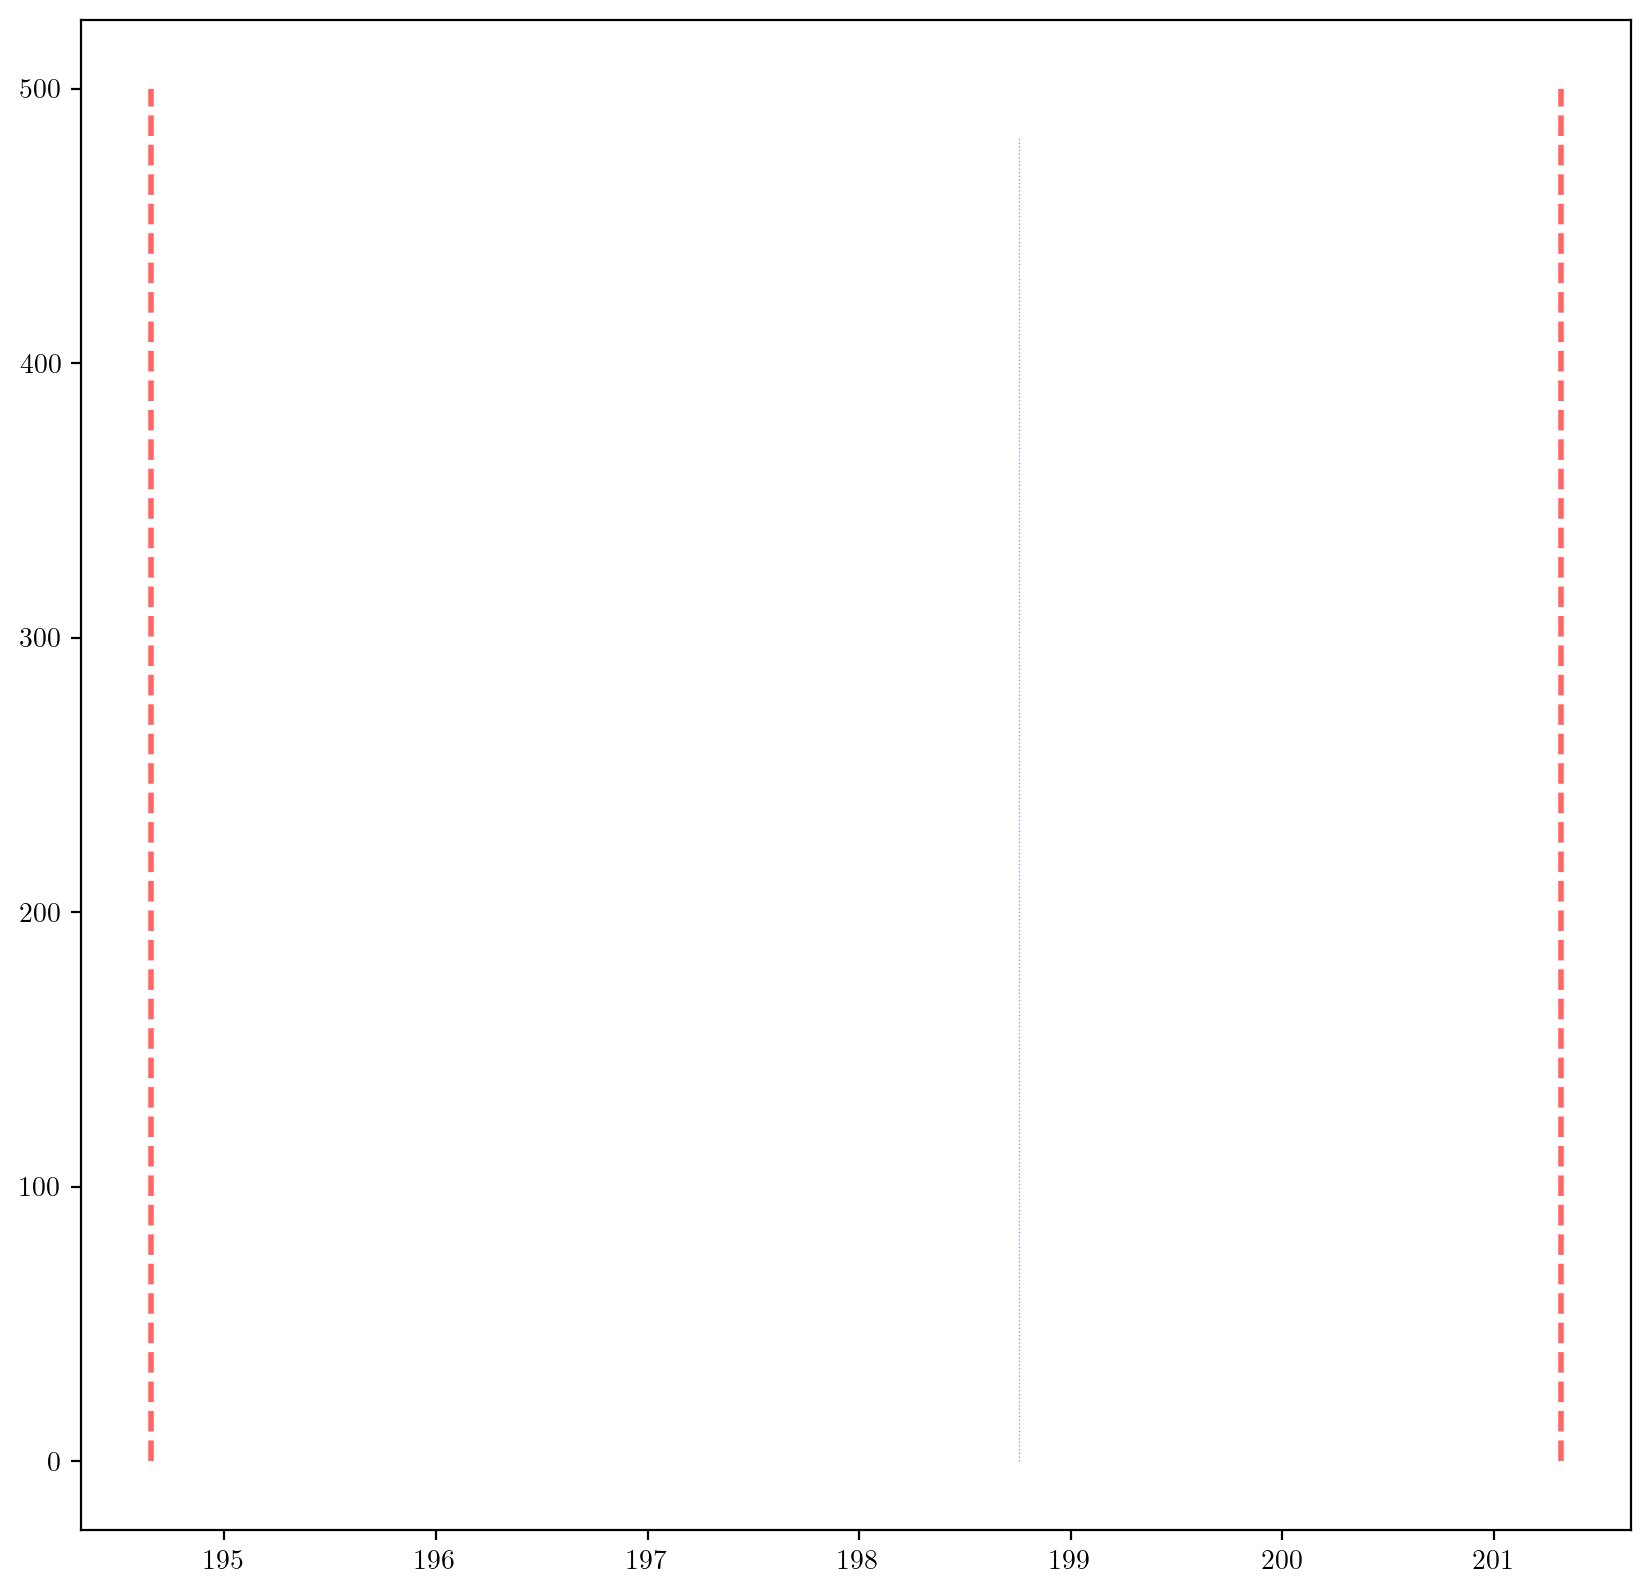

In [39]:
""" def tester(x,a,m):
    res = []
    for ii, el in enumerate(x):
        res.append((a_cut[ii]*a)+m)
    return res """

from scipy.special import erfc
import itertools
from scipy.stats import chi2_contingency
import scipy.stats

plt.figure(figsize=(10,10))

def tester2(x,tau,A,v0, sigma, mu):
    """     sigma = np.abs(sigma)
    tau = np.abs(tau)
    A = np.abs(A)
    mu = np.abs(mu) """
    #print(sigma,mu,tau,A,v0)
    #return v0 + 0.5*A * np.exp(0.5 * (sigma/tau)**2 - (x-mu)/tau) * erfc(1/np.sqrt(2)* (sigma/tau - (x-mu)/sigma))
    temp = []
    for ii, val in enumerate(x):
        temp.append(((A/2 * np.exp(((1*sigma**2)/(2*(tau**2)))-((ii-mu)/tau)) * math.erfc((1*sigma/(math.sqrt(2)*tau))-((ii-mu)/sigma)))))
    return temp
    return [(v0 + (A/2 * np.exp(((1*sigma**2)/(2*(tau**2)))-((t-mu)/tau)) * math.erfc((1*sigma/(math.sqrt(2)*tau))-((t-mu)/sigma)))) for t in x]

def tester4(x,tau,A,sigma,mu):
    print(type(x))
    print(x)
    return A/2.0 * np.exp(0.5 * (sigma/tau)**2 - (x-mu)/tau) * erfc(1.0/np.sqrt(2.0) * (sigma/tau - (x-mu)/sigma))

def tester3(x,tau, A, sigma,mu):
    #mu = 385
    #print(sigma,mu,tau,A,v0)
    print(type(x))
    print(np.shape(x))
    print(type(A))
    print(type(tau))
    print(type(sigma))
    print(type(mu))
    return A/2.0 * np.exp(((1.0*sigma**2)/(2.0*(tau**2)))-((x-mu)/tau)) * erfc(1.0/np.sqrt(2.0) * (sigma/tau-(x-mu)/sigma))
    #return v0 + 0.5*A * np.exp(0.5 * (sigma/tau)**2 - (x-mu)/tau) * erfc(1/np.sqrt(2)* (sigma/tau - (x-mu)/sigma))
    temp = []
    for ii, val in enumerate(x):
        temp.append(((A/2.0 * np.exp(((1.0*sigma**2)/(2.0*(tau**2)))-((ii-mu)/tau)) * math.erfc((1.0*sigma/(math.sqrt(2.0)*tau))-((ii-mu)/sigma)))))
        #base + V0/2.0 * np.exp(0.5 * (sigma/tau)**2 - (x-mu)/tau) * erfc(1.0/np.sqrt(2.0) * (sigma/tau - (x-mu)/sigma))
    return temp

#popt,pcov=curve_fit(tester,cut, Ds[volt].Ch[0].Time[lower:upper],bounds=([0.5,20],[1.5,50]))
""" popt,pcov=curve_fit(tester,cut, Ds[volt].Ch[0].Time[lower:upper])
perr = np.sqrt(np.diag(pcov))
plt.plot(Ds[volt].Ch[0].Time,sample,color='k',label='Raw',lw=1,alpha=1)
plt.plot(Ds[volt].Ch[0].Time[lower:upper],a_cut,color='blue',label='Averaged',lw=2,alpha=0.5)
plt.plot(Ds[volt].Ch[0].Time[lower:upper],tester(cut,*popt),color='red',label='Fit',lw=2,alpha=0.5)
#plt.xlim(180,400)
plt.legend(loc=1)
plt.title(f'p_err: {perr} | $\chi^2$: ??')
plt.close()

plt.plot(Ds[volt].Ch[0].Time,sample,color='k',label='Raw',lw=1,alpha=1)
plt.plot(Ds[volt].Ch[0].Time[lower:upper],a_cut,color='blue',label='Averaged',lw=2,alpha=0.5)
plt.plot(Ds[volt].Ch[0].Time[lower:upper],tester(cut,*popt),color='red',label='Fit',lw=2,alpha=0.5)
plt.xlim(180,350)
plt.legend(loc=1)
plt.title(f'p_err: {perr} | $\chi^2$: ??')
plt.close() """

#print(f'Sampling rate: {Ds[volt].sampling_freq}')
print('\n-------------\n')
""" 
popt,pcov=curve_fit(tester,cut, Ds[volt].Ch[0].Time[lower:upper],p0=[1,0],bounds=([0,0],[10,10]))
perr = np.sqrt(np.diag(pcov))
plt.plot(Ds[volt].Ch[0].Time[lower:upper],cut,color='k',label='Raw',lw=1,alpha=1)
plt.plot(Ds[volt].Ch[0].Time[lower:upper],a_cut,color='blue',label='Averaged',lw=2,alpha=0.5)
plt.plot(Ds[volt].Ch[0].Time[lower:upper],tester(cut,*popt),color='red',label='Fit',lw=2,alpha=0.5)
#plt.xlim(180,400)
plt.title(f'p_err: {perr}')
plt.legend(loc=1)
plt.close()

peaks = find_peaks(sample,distance=100,prominence=100)[0]
for p in peaks:
    time = [*Ds[volt].Ch[0].Time][p]
    plt.scatter(time,sample[p],marker='+',color="lime")

plt.plot(Ds[volt].Ch[0].Time[lower:upper],cut,color='k',label='Raw',lw=1,alpha=1)
plt.plot(Ds[volt].Ch[0].Time[lower:upper],a_cut,color='blue',label='Averaged',lw=2,alpha=0.5)
plt.title(f'p_err: {perr} | $\chi^2$: ??')
plt.plot(Ds[volt].Ch[0].Time[lower:upper],tester(cut,*popt),color='red',label='Fit',lw=2,alpha=0.5)
plt.xlim(180,350)
plt.legend(loc=1)
plt.close()
print(f'Sampling rate: {Ds[volt].sampling_freq}')

for s in samples[:30]:
    plt.plot(Ds[volt].Ch[0].Time,s,color='k',label='Raw',lw=1,alpha=1)
    peaks = find_peaks(s,distance=100,prominence=100)[0]
    for p in peaks:
        time = [*Ds[volt].Ch[0].Time][p]
        plt.scatter(time,s[p],marker='+',color="lime")
    plt.show() """

sample_max = float(sample[int(find_peaks(sample,prominence=30)[0])])
plt.vlines(Ds[volt].Ch[0].Time[int(find_peaks(sample,prominence=30)[0])],0,sample_max,color='blue',linestyles='dotted',alpha=0.4,lw=0.5)
print(f'{ANSI_GREEN}Sample max {sample_max}{ANSI_RESET}')
probable_baseline = np.mean(sample[0:10])
print(f'DEPRECATED: Prob baseline {probable_baseline}')
prob_rise_x = np.argmax(sample)-8
print(f'DEPRECATED: Prob rise {prob_rise_x}')
print(f'Sample max Ae-1: {sample_max**(np.e**-1)}')
prob_return_x = None

for ii, val in enumerate(sample):
    if ii > find_peaks(sample,prominence=30)[0] and np.abs(val) < sample_max - sample_max**(np.e**-1):
        prob_return_x = (ii)
        break

est_tau = prob_return_x-prob_rise_x
est_tau2 = Ds[volt].Ch[0].Time[prob_return_x] - Ds[volt].Ch[0].Time[prob_rise_x]
print(f'{ANSI_GREEN}Prob return at index {prob_return_x} (amplitude {sample[prob_return_x]}) and time {est_tau2} (i range {est_tau}){ANSI_RESET}')
plt.vlines([Ds[volt].Ch[0].Time[prob_return_x], Ds[volt].Ch[0].Time[prob_rise_x]],0,500,linestyles='dashed',color='r',alpha=0.6,lw=2)


#wiggle room:
TAU = 100
A = 50 
BASELINE = 5
RISE = 5
MIN_SIG = 1
MAX_SIG = 2
#est_tau2 = 80
p0=[float(est_tau),sample_max,1.60,382.0]
print("p0 (tau,A,sigma): ",p0)

#print("est ", Ds[volt].Ch[0].Time[prob_return_x], est_tau, sample_max, probable_baseline, prob_rise_x)
print("low (tau,A,sigma,...)",est_tau-TAU,sample_max-A,MIN_SIG,probable_baseline-BASELINE,MIN_SIG,prob_rise_x-RISE)
print("up (tau,A,sigma,...)", est_tau+TAU,sample_max+A,MAX_SIG,probable_baseline+BASELINE,MAX_SIG,prob_rise_x+RISE)

sample = np.asarray(sample).reshape(-1)

#                                                                       tau,A,v0, sigma, mu):
popt,pcov=curve_fit(tester3, Ds[volt].Ch[0].Time,sample,maxfev=100000000,p0=p0)#, bounds=([est_tau-TAU,sample_max-A,MIN_SIG,380]   ,   [est_tau+TAU,sample_max+A,MAX_SIG,384]))

""" perms = []
for i in itertools.product(np.arange(est_tau-TAU,est_tau+TAU,1),np.arange(sample_max-A,sample_max+A,1),np.arange(probable_baseline-BASELINE,probable_baseline+BASELINE,1),np.arange(prob_rise_x-RISE, prob_rise_x+RISE,1)):
    perms.append([*i])
print("Len: ",len(perms))
m = 0
covs = []
for p in perms:
    tmp = tester2(sample, tau=p[0], A=p[1], v0=p[2],sigma=1.6,mu=p[3])
    cov = np.cov(sample, tmp)
    perr = np.sqrt(np.diag(cov))
    #if perr[1] > 10e+10: continue
    covs.append(perr[1])
    try: chi = chi2_contingency(sample,temp)[0]
    except: print('\r',p)
    else: pass
    if chi > 0.0: m = chi
print(np.argmin(covs)," -> ",covs[np.argmin(covs)], " for ",perms[np.argmin(covs)])
print(m)
print(len(covs))
print(len(np.arange(0,len(covs))))
plt.scatter(np.arange(0,len(covs)),covs,marker='+')
plt.xlim(0,50)
plt.ylim(0,100)
plt.show() """

#print(f'Tau: {popt[0]}\nA: {popt[1]}\nV0: {popt[2]}\nSigma: {popt[3]}\nMu: {popt[4]}\n')
perr = np.sqrt(np.diag(pcov))
print(f'{ANSI_CYAN}Tau: {popt[0]}\nA: {popt[1]}\nSigma: {popt[2]}\n{ANSI_RESET}\nMu: {popt[3]}')
if perr[0] > 1: print(f'{ANSI_RED}ERR: {perr}{ANSI_RESET}')
else: print(f'{ANSI_GREEN}ERR: {perr}{ANSI_RESET}')
#print(f'popt: {popt}')
#print(f'pcov: {pcov}')
plt.plot(Ds[volt].Ch[0].Time,sample,color='k',label='Raw',lw=1,alpha=1)
#plt.plot(Ds[volt].Ch[0].Time,averaged,color='blue',label='Averaged',lw=2,alpha=0.5)
print("Curve fit perr: ",np.sqrt(np.diag(np.cov(sample,tester3(sample,*popt)))))
print(f"{ANSI_YELLOW}Manual fit{ANSI_RESET} perr: ",np.sqrt(np.diag(np.cov(sample,tester3(sample, tau=86, A=55, sigma=1.6,mu=382)))))
plt.plot(Ds[volt].Ch[0].Time,tester3(sample, tau=popt[0], A=popt[1], sigma=popt[2],mu=popt[3]),color='red',label='Fit',lw=2,alpha=0.5)
#plt.plot(Ds[volt].Ch[0].Time,tester3(sample, tau=103, A=510, sigma=3,mu=382),color='lime',label='Manual',lw=2,alpha=0.5)
#plt.xlim(180,400)
#print(chisquare(sample,tester2(sample, tau=90, A=500, v0=84, sigma=1.6, mu=390)))
plt.title(f'p_err: {perr}')
plt.ylim(-10,sample_max+10)
plt.xlim(150,500)
plt.legend(loc=1)
plt.show()

print(chisquare(sample,tester3(sample, tau=popt[0], A=popt[1], sigma=popt[2],mu=popt[3])))

#   TODO: run the code TWICE to load all plotlib settings

In [ ]:
sys.exit()

peaks = {}
import itertools
mpl.rcParams['figure.dpi']= 200

def gain(spikes,sh_time,plot=True,prominence=16,distance=12,bin_w=2,lim=10,skip=False):

    BIN_W = bin_w
    SUBS = False
    if not plot: SUBS = False
    PROMINENCE = prominence
    DISTANCE = distance
    MIN = 7
    
    # plt.title(f"Shaping time: {sh_time} | OV: {volt}V")
    # plt.hist(peak_amps[sh_time],bins=np.arange(0,1000,BIN_W+1),histtype='step', color='royalblue')
    # plt.hist(peak_amps[sh_time],bins=np.arange(0,1000,BIN_W+2),histtype='step', color='firebrick')
    # plt.hist(peak_amps[sh_time],bins=np.arange(0,1000,BIN_W+3),histtype='step', color='deepskyblue')
    x, y = np.histogram(spikes,bins=np.arange(0,1000,BIN_W))
    # plt.ylim(0,12)
    # plt.xlim(0,800)
    #print(len(x))
    #print(len(y))

    p_indexes = find_peaks(x, prominence=PROMINENCE,distance=DISTANCE)[0]

    limiter = lim
    
    """ while (len(p_indexes) < MIN) and (BIN_W<limiter):
        BIN_W=BIN_W+1
        x, y = np.histogram(spikes,bins=np.arange(0,1000,BIN_W))
        p_indexes = find_peaks(x, prominence=PROMINENCE,distance=DISTANCE)[0] """


    if SUBS: plt.figure(figsize=(12,80)).suptitle(f"Shaping time: {sh_time} | OV: {volt}V | BIN_W: {BIN_W}", fontsize=16)
    elif plot: plt.figure(figsize=(12,5)).suptitle(f"Shaping time: {sh_time} | OV: {volt}V | BIN_W: {BIN_W}", fontsize=16)
    #plt.subplot(1,2,1)
    if SUBS: plt.subplot(15,1,1)
    elif plot and not skip: plt.subplot(1,2,1)
    if plot: plt.hist(spikes,bins=np.arange(0,1000,BIN_W),histtype='step', color='black')

    x = np.asarray(x).reshape(-1)
    y = np.asarray(y).reshape(-1)
    y = y[:-1]

    if len(p_indexes) < MIN:
        if plot: plt.close()
        if plot: plt.figure(figsize=(6,8)).suptitle(f"NOT SEL. --> Shaping time: {sh_time} | OV: {volt}V | BIN_W: {BIN_W}", fontsize=16)
        if plot: plt.hist(spikes,bins=np.arange(0,1000,BIN_W),histtype='step', color='black')
        if plot: plt.show()
        return {'pks': None, 'err': None, 'gain': None}

    TEST_PEAK = 0
    first_pe_max=y[p_indexes[TEST_PEAK]] # The x-value of the 2nd peak.Index=1 means the second peak will be used for getting fit parameters
    #print(f'{ANSI_CYAN}[{volt}V|{sh_time}]:{ANSI_RESET} First-pe-max: {first_pe_max}')
    max_value=x[p_indexes[TEST_PEAK]] # The height of the 2nd peak
    #print(f'{ANSI_CYAN}[{volt}V|{sh_time}]:{ANSI_RESET} max: {max_value}')
    x_idx_array=(x<0.5*max_value) & (y>first_pe_max)# returns a boolean array where both conditions are true
    #print(f'{ANSI_CYAN}[{volt}V|{sh_time}]:{ANSI_RESET} x-idx: {x_idx_array}')
    right_side_x= y[np.where(x_idx_array)[0][0]] #finding the first time where x_idx_array is True
    #print(f'{ANSI_CYAN}[{volt}V|{sh_time}]:{ANSI_RESET} right: {right_side_x}')
    sigma_guess=np.abs(first_pe_max-right_side_x) #We need this to fit the width of the Gaussian peaks
    #print(f'{ANSI_CYAN}[{volt}V|{sh_time}]:{ANSI_RESET} sigma guess: {sigma_guess}')

    cut= (y < first_pe_max+sigma_guess) & (y > first_pe_max-sigma_guess) # This cut helps to fix the width of the peak-fit
    popt, pcov = None,None
    try: popt,pcov=curve_fit(gauss,y[cut],x[cut],p0=[max_value,first_pe_max,sigma_guess])
    except:
        #print(f'{ANSI_CYAN}[{volt}V|{sh_time}]:{ANSI_RED} Gaussian fit FAILED for test peak with values:\n    X: {first_pe_max}\n    Y: {max_value}\n    right side X: {right_side_x}\n    Sigma guess: {sigma_guess}{ANSI_RESET}')
        if plot: plt.title(f'V - 1st fit FAILED - V')
        if plot: plt.vlines(first_pe_max,0,max_value, linestyles='dotted', color='lime',alpha=0.5)
    else:
        if plot: plt.plot(y[cut],gauss(y[cut],*popt),color='red',label='Fit',lw=2,alpha=0.5)
    #plt.xlim(50,200)
    #plt.scatter(popt[1],popt[0],color='royalblue',marker='+')
    #print(cut)
    #print(popt)

    p_temp = []
    err_p_temp = []
    for i,peak in enumerate(p_indexes): #here we ignore the first peak because it could be the pedestal
        new_first_pe_max=y[peak] #x-value of the peak
        new_max_value=x[peak] #height of the peak
        new_x_idx_array=(x<0.5*new_max_value) & (y>new_first_pe_max) # returns a boolean array where both conditions are true
        new_right_side_x=None
        try: new_right_side_x= y[np.where(new_x_idx_array)[0][0]] #finding the first time where x_idx_array is True
        except: return {'pks': None, 'err': None, 'gain': None}
        new_sigma_guess=np.abs(new_first_pe_max-new_right_side_x) #We need this to fit the width of the Gaussian peaks


        new_cut= (y < new_first_pe_max+new_sigma_guess) & (y > new_first_pe_max-new_sigma_guess) # This cut helps to fix the width of the peak-fit
        #print(f'{ANSI_CYAN}[{volt}V|{sh_time}]:{ANSI_RESET} Peak (i={i}) at ({new_first_pe_max},{new_max_value}): right side {new_right_side_x}, sigma guess {new_sigma_guess}')
        if SUBS: plt.subplot(15,1,2+i)
        popt_new,pcov_new=None,None
        try: popt_new,pcov_new=curve_fit(gauss,y[new_cut],x[new_cut],p0=[new_max_value,new_first_pe_max,new_sigma_guess],maxfev=100000)
        except:
            #print(f'{ANSI_CYAN}[{volt}V|{sh_time}]:{ANSI_RED} Gaussian fit FAILED for peak (i={i}) values:\n    X: {new_first_pe_max}\n    Y: {new_max_value}\n    right side X: {new_right_side_x}\n    Sigma guess: {new_sigma_guess}{ANSI_RESET}')
            if SUBS: plt.title(f'V - Gaussian fit FAILED - V')
            if SUBS: plt.subplot(15,1,1)
            #if plot: plt.plot(y[new_cut],gauss(y[new_cut],*popt_new),color='purple',label='Fit',lw=2,alpha=0.5)
            #if plot: plt.scatter(popt_new[1],popt_new[0],color='lime',marker='+')
            if plot: plt.scatter(new_first_pe_max,new_max_value,color='lime',marker='+')
        else:
            if SUBS: plt.plot(y[new_cut],gauss(y[new_cut],*popt_new),color='r',label='Fit',lw=3,alpha=0.8) # Here we plot the fit on all the peaks
            p_temp.append(popt_new[1]) #Here we append the value of the peak fit mean
            if SUBS: plt.hist(spikes,bins=np.arange(0,1000,BIN_W),histtype='step', color='black')
            perr = np.sqrt(np.diag(pcov_new))
            err_p_temp.append(perr[1])
            if i == 0 and SUBS: plt.scatter(popt_new[1],popt_new[0],color='royalblue',marker='+',label=f'{i+1}st peak')
            elif i == 1 and SUBS: plt.scatter(popt_new[1],popt_new[0],color='royalblue',marker='+',label=f'{i+1}nd peak')
            elif i == 2 and SUBS: plt.scatter(popt_new[1],popt_new[0],color='royalblue',marker='+',label=f'{i+1}rd peak')
            else:
                if plot: plt.scatter(popt_new[1],popt_new[0],color='royalblue',marker='+',label=f'{i+1}th peak')
            if SUBS: plt.xlim(y[peak]-80,y[peak]+80)
            if SUBS: plt.legend(loc=1)

            if SUBS: plt.subplot(15,1,1)
            if plot:
                if not skip: plt.plot(y[new_cut],gauss(y[new_cut],*popt_new),color='r',label='Fit',lw=3,alpha=0.8)
                else: plt.plot(y[new_cut],gauss(y[new_cut],*popt_new),color='purple',label='Fit',lw=2,alpha=0.8)
            if plot: plt.scatter(popt_new[1],popt_new[0],color='royalblue',marker='+')

    # -----------------------------------------
    if skip:
        plt.show()
        return None
    if not SUBS and plot: plt.subplot(1,2,2)
    try: popt_temp,pcov_temp=curve_fit(line_gain,np.arange(0,len(p_temp)),p_temp,p0=[90,5],maxfev=10000) #Use the straight line fit here
    except: return {'pks': None, 'err': None, 'gain': None}
    if plot: plt.plot(np.arange(0,len(p_temp)),line_gain(np.arange(0,len(p_temp)),*popt_temp),color='k',label=(str(np.round(popt_temp[0],2)))+'$\pm$'+str(np.round(np.sqrt(np.diag(pcov_temp))[0],2))+' ADC/PE') # plot the straight line fit
    if plot: plt.xticks(np.arange(1,len(p_temp)+1))
    perr = np.sqrt(np.diag(pcov_temp))[0]
    if perr > 1.2:
        pass#print(f'{ANSI_CYAN}[{volt}V|{sh_time}]:{ANSI_RESET} \u001b[41;1mLine fitted on {len(p_temp)}– GAIN {popt_temp[0]} | ERR {perr}{ANSI_RESET}')
        #print()
    else:
        if plot: plt.legend(loc=2)
        #print(f'{ANSI_CYAN}[{volt}V|{sh_time}]:{ANSI_RESET} \u001b[44mLine fitted on {len(p_temp)} – GAIN {popt_temp[0]} | ERR {perr}{ANSI_RESET}')
        

        if plot:
            plt.errorbar(np.arange(0,len(p_temp)),p_temp, yerr=perr, capsize=5, color='r', marker='o', ms=5, ls='None', label='Data')
            if not sh_time in peaks.keys(): peaks[sh_time] = OrderedDict()
            peaks[sh_time][volt] = {'popt': popt_temp[0], 'perr': perr}
    if plot: plt.show()

    return {'pks': len(p_temp), 'err': perr, 'gain': popt_temp}

perms = []
for i in itertools.product(np.arange(10,20,1),np.arange(5,30,5),np.arange(1,10,1)):
    perms.append([*i])

print(f'Testing {len(perms)} permutations\n')
done = 0
for volt in voltages[-1:]:
    x_vals = []
    y_vals = []
    peak_amps = v_data[volt]

    for sh_time in peak_amps.keys():
        var = []
        errs = []
        pks = []
        prom = []
        dist = []
        bins = []
        start = datetime.now()
        for triplet in perms:
            result = gain(peak_amps[sh_time],sh_time=sh_time,plot=False, prominence=triplet[1],distance=triplet[0],bin_w=triplet[2],lim=10)
            if result['err'] is None: continue
            if not result['pks'] is None:
                if float(result['pks']) < 6: continue
            errs.append(result['err'])
            pks.append(result['pks'])
            prom.append(triplet[1])
            dist.append(triplet[0])
            bins.append(triplet[2])
        
        if len(errs) < 1:
            print('Skipping')
            continue
        
        smallest = np.argmin(errs)
        print(f'Smallest error ({errs[smallest]}) at {smallest} (P: {prom[smallest]}, D: {dist[smallest]}, B: {bins[smallest]}) for {pks[smallest]} pks')
        if errs[smallest] > 0.7:
            print('Skipping due to error being too large')
            gain(peak_amps[sh_time],sh_time=sh_time,plot=True, prominence=prom[smallest],distance=dist[smallest],bin_w=bins[smallest],lim=10,skip=True)
            continue

        gain(peak_amps[sh_time],sh_time=sh_time,plot=True, prominence=prom[smallest],distance=dist[smallest],bin_w=bins[smallest],lim=10)
        end = datetime.now()
        print(end-start)
        print(f'\rTime to completion: {(end-start).total_seconds()*(len(peak_amps.keys())*len(voltages)-done)} seconds')
        done += 1


    #print(f'{total} waveforms in total (unfiltered) from {files} files')

    #print('----------------------------------------------')


Testing 450 permutations



[29.5V|2e-06]: Gain 0.21526121153792133, Err 0.057641256876035996 added to the array
[31.0V|2e-06]: Gain 68.53737636876755, Err 0.09601941422915797 added to the array
[31.5V|2e-06]: Gain 78.47263689759036, Err 0.09836177286716882 added to the array
[32.0V|2e-06]: Gain 87.70340642222219, Err 0.17255705600048665 added to the array
[32.5V|2e-06]: Gain 96.84617539534946, Err 0.18126634751013573 added to the array
[33.0V|2e-06]: Gain 105.31299170814239, Err 0.24657335215235732 added to the array
[33.5V|2e-06]: Gain 114.55839766462654, Err 0.2717766992323116 added to the array
[34.0V|2e-06]: Gain 123.7910148961037, Err 0.7523878616060681 added to the array
[34.5V|2e-06]: Gain 130.65432937469586, Err 0.48459975494248253 added to the array


ValueError: operands could not be broadcast together with shapes (11,) (9,) 

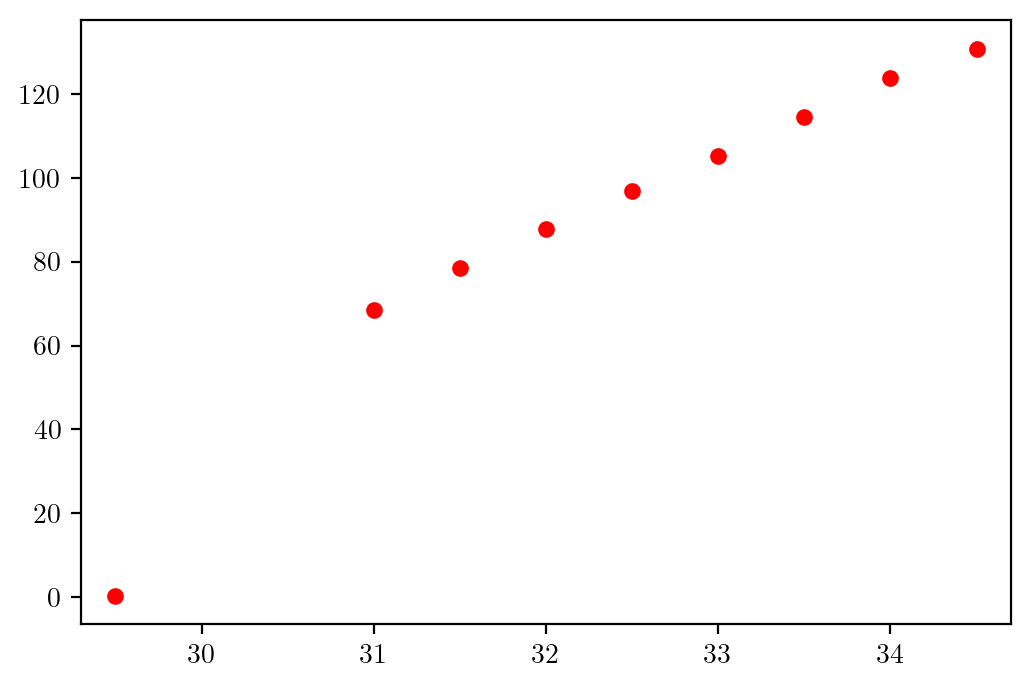

In [ ]:
def line(x,a,b):
    return a*(x-b)

summarized_data = {}
#plt.figure(figsize=(10,10))
for ii, sh_time in enumerate(peaks.keys()):

    #print(peaks[sh_time])

    gain_temp = []
    err_temp = []
    for volt in peaks[sh_time].keys():
        opt = float(peaks[sh_time][volt]['popt'])
        err = peaks[sh_time][volt]['perr']
        if err < 1e-08:
            err = 1e-08
            print(f'{ANSI_CYAN}[{float(volt)+27.5}V|{sh_time}]:{ANSI_YELLOW} Gain {opt} --> !NOTE:  Error is too small --> replacing {peaks[sh_time][volt]["perr"]} with {err}{ANSI_RESET}') 
        else: print(f'{ANSI_CYAN}[{float(volt)+27.5}V|{sh_time}]:{ANSI_RESET} Gain {opt}, Err {err} added to the array{ANSI_RESET}')        

        gain_temp.append(opt)
        err_temp.append(err)

    volts = [float(x) + 27.5 for x in np.array([*peaks[sh_time].keys()])]
    x_data=np.arange(np.min(volts),np.max(volts)+0.1,0.5)
    plt.xlim(np.min(volts)-0.2,np.max(volts)+0.2)

    plt.errorbar(volts,gain_temp,yerr=err_temp,label=str(sh_time)+' Data',fmt='o',ms=5,color='red')
    popt_0,pcov_0=curve_fit(line,x_data,gain_temp,p0=[31,27],sigma=err_temp)
    if pcov_0[0][0] == np.inf: print(f'{ANSI_RED} ---- COVARIANCE ERROR ---- {ANSI_RESET}')
    label = str(sh_time)+' - BV= '+str(np.round(popt_0[1],2))+ '$\pm$'+ str(np.round(np.sqrt(np.diag(pcov_0)[1]),2))+' V'
    plt.plot(x_data, line(volts,*popt_0), color=colors[-ii], ls='--', label=label)
    # plt.plot(x_data,line(x_data,*popt_260),color=colors[1],label='BV= '+str(np.round(popt_260[1],2))+ '$\pm$'+ str(np.round(np.sqrt(np.diag(pcov_260)[1]),2))+' V',ls='--')
    #plt.ylabel('Gain (ADC/PE)')
    plt.xlabel('Bias Voltage (V)')
    plt.legend(loc=2)
    plt.title(f'Shaping time: {sh_time}')
    plt.show()
#plt.legend(loc=2)
#plt.show()

In [ ]:
sys.exit()
""" def line(x,a,b):
    return a*x+b """

' def line(x,a,b):\n    return a*x+b '

In [ ]:
""" plt.figure()
plt.xlim(np.min(voltages.astype(float)), np.max(voltages.astype(float)))
plt.xlabel('Overvoltage [V]')
plt.ylabel('Max Amplitude [mV]')

ys = {}
ys[0] = []
ys[1] = []

for volt in voltages.astype(str): 
    markers = ['o', 'X']
    for i,ch in enumerate(Ds[volt].Ch):
        x = [float(volt)]*len(ch.Max)
        y = ch.Max
        ys[i].append(y[0])
        plt.scatter(x,y, marker=markers[i], color=colors[i], s=5)

xval = np.array([float(x) for x in voltages])
popt1,pcov1 = curve_fit(line, xval, np.array(ys[0]))      
popt2,pcov2 = curve_fit(line, xval, np.array(ys[1]))      

plt.plot(xval, line(xval,*popt1), label='Unfiltered')
plt.plot(xval, line(xval,*popt2), label='Filtered')
plt.legend(loc='upper left')
plt.show()  """

" plt.figure()\nplt.xlim(np.min(voltages.astype(float)), np.max(voltages.astype(float)))\nplt.xlabel('Overvoltage [V]')\nplt.ylabel('Max Amplitude [mV]')\n\nys = {}\nys[0] = []\nys[1] = []\n\nfor volt in voltages.astype(str): \n    markers = ['o', 'X']\n    for i,ch in enumerate(Ds[volt].Ch):\n        x = [float(volt)]*len(ch.Max)\n        y = ch.Max\n        ys[i].append(y[0])\n        plt.scatter(x,y, marker=markers[i], color=colors[i], s=5)\n\nxval = np.array([float(x) for x in voltages])\npopt1,pcov1 = curve_fit(line, xval, np.array(ys[0]))      \npopt2,pcov2 = curve_fit(line, xval, np.array(ys[1]))      \n\nplt.plot(xval, line(xval,*popt1), label='Unfiltered')\nplt.plot(xval, line(xval,*popt2), label='Filtered')\nplt.legend(loc='upper left')\nplt.show()  "

In [ ]:
""" plt.figure() 
plt.xlim(0,400)
plt.xlabel('Time [$\mu$s]')
plt.ylabel('Amplitude [mV]')
for volt in voltages: 
    markers = ['o', 'x']
    for i,ch in enumerate(Ds[volt].Ch[1:]):
        plt.plot(ch.Time, np.mean(ch.Amp, axis=0), label='{}V'.format(volt))
plt.legend(loc='upper left', ncol=1)
plt.show()  """

" plt.figure() \nplt.xlim(0,400)\nplt.xlabel('Time [$\\mu$s]')\nplt.ylabel('Amplitude [mV]')\nfor volt in voltages: \n    markers = ['o', 'x']\n    for i,ch in enumerate(Ds[volt].Ch[1:]):\n        plt.plot(ch.Time, np.mean(ch.Amp, axis=0), label='{}V'.format(volt))\nplt.legend(loc='upper left', ncol=1)\nplt.show()  "

In [ ]:
def gauss(x,a,mu,sigma):
    return (a*np.exp(-0.5*((x-mu)/sigma)**2))

In [ ]:
def gain_calculator(PATH):
    BINS=20 #Number of bins to rebin the MCA data with
    N_peaks= 4# Number o peaks to use for calculating the gain
    gain_list=[] #empty list to fill in the values of gain, returned at the end of this function
    gain_err=[] #empty list to fill in the values of gain fit error, returned at the end of this function
    Files = glob.glob(PATH+'mca_*.h5')
    #for loop to loop over all the files
    for i,file in enumerate(natsorted(Files)): 
        print(i,file)
        f = h5py.File(file, 'r')  
        ch2 = f.get('ch2')
        for key in ch2.keys():
            df = np.array(ch2.get(key))
        h = df
        hx = np.arange(0,len(h),1)
        hx,h = rebin(hx,h, BINS)

        gain_temp=[]#reset the gain temp list here to store gain values for one file
        gain_temp_err=[]#reset the gain temp list here to store gain values for one file
        #Use scipy find_peaks to find peaks starting with a very high prominence 
        PROMINENCE=1000 #This prominence is re-set here to ensure that every file starts out with a high prominence
        peaks,pdict=find_peaks(h,prominence=PROMINENCE,width=50)
        peak_length=len(peaks)
        #We want to ensure that using a high prominence gives us at least 3 peaks to fit a straight line to. If it doesn't we reduce prominence till we get at least 3 peaks. N_peaks is set above
        while (peak_length<N_peaks+1):
            PROMINENCE=PROMINENCE-1
            peaks,pdict=find_peaks(h,prominence=PROMINENCE,width=10)
            peak_length=len(peaks)
        
        #To avoid fitting the pedestal, we ignore the first peak. In case the pedestal isn't there, then first peak gets ignored. This shouldn't change gain or BV calculation
        first_pe_max=hx[peaks[1]] # The x-value of the 2nd peak.Index=1 means the second peak will be used for getting fit parameters
        max_value=h[peaks[1]] # The height of the 2nd peak
        x_idx_array=(h<0.5*max_value) & (hx>first_pe_max)# returns a boolean array where both conditions are true
        right_side_x= hx[np.where(x_idx_array)[0][0]] #finding the first time where x_idx_array is True
        sigma_guess=np.abs(first_pe_max-right_side_x) #We need this to fit the width of the Gaussian peaks

        plt.figure(figsize=(12,5)) # Call the figure here
        plt.subplot(1,2,1) #This subplot will plot the position of the peaks and also the data
        plt.yscale('log')
        plt.plot(hx[peaks],h[peaks],'*') # plot the peak markers
        plt.step(hx,h,lw=1) #plot the signal
        cut= (hx < first_pe_max+sigma_guess) & (hx > first_pe_max-sigma_guess) # This cut helps to fix the width of the peak-fit
        popt,pcov=curve_fit(gauss,hx[cut],h[cut],p0=[max_value,first_pe_max,sigma_guess]) # We use curve_fit to return the optimal parameters and the covariance matrix
        plt.plot(hx[cut],gauss(hx[cut],*popt),color='green',label='Fit',lw=2,alpha=0.5) # Here we plot the fit on the 2nd peak to see if everything looks ok.
        for i,peak in enumerate(peaks[:]): #here we ignore the first peak because it could be the pedestal
            new_first_pe_max=hx[peak] #x-value of the peak
            new_max_value=h[peak] #height of the peak
            new_x_idx_array=(h<0.5*new_max_value) & (hx>new_first_pe_max) # returns a boolean array where both conditions are true
            new_right_side_x= hx[np.where(new_x_idx_array)[0][0]] #finding the first time where x_idx_array is True
            new_sigma_guess=np.abs(new_first_pe_max-new_right_side_x) #We need this to fit the width of the Gaussian peaks


            new_cut= (hx < new_first_pe_max+new_sigma_guess) & (hx > new_first_pe_max-new_sigma_guess) # This cut helps to fix the width of the peak-fit
            popt_new,pcov_new=curve_fit(gauss,hx[new_cut],h[new_cut],p0=[new_max_value,new_first_pe_max,new_sigma_guess],maxfev=100000) # We use curve_fit to return the optimal parameters and the covariance matrix
            plt.plot(hx[new_cut],gauss(hx[new_cut],*popt_new),color='r',label='Fit',lw=3) # Here we plot the fit on all the peaks
            gain_temp.append(popt_new[1]) #Here we append the value of the peak fit mean 
            perr = np.sqrt(np.diag(pcov_new))
            gain_temp_err.append(perr[1])
        print(gain_temp)
        print(np.diff(gain_temp))
        print(np.mean(np.diff(gain_temp)))

        plt.subplot(1,2,2) #This subplot shows the straight line fit to the peak means to obtain the slope/gain
        popt_temp,pcov_temp=curve_fit(line_gain,np.arange(0,len(peaks)),gain_temp,p0=[90,5],maxfev=10000) #Use the straight line fit here
        plt.plot(np.arange(0,len(peaks)),line_gain(np.arange(0,len(peaks)),*popt_temp),color='k',label=(str(np.round(popt_temp[0],2)))+'$\pm$'+str(np.round(np.sqrt(np.diag(pcov_temp))[0],2))+' ADC/PE') # plot the straight line fit
        

        plt.errorbar(np.arange(0,len(peaks)),gain_temp, yerr=gain_temp_err, capsize=5, color='r', marker='o', ms=5, ls='None', label='Data') #plot the values of the peak means
        plt.legend(loc=2)
        plt.show() #show the plot
        gain_list.append(popt_temp[0]) #append the gain values to obtain BV later
        gain_err.append(np.sqrt(np.diag(pcov_temp))[0]) #append the straight line error fit 
    return(np.array(gain_list),np.array(gain_err))

0 /Users/tizi/Documents/YALE_WL.nosync/data/20220609/mca_keith_2.00OV.h5
[18.210866381415116, 65.18146133164583, 114.87401065882027, 164.7562800448003, 214.24623957330962]
[46.97059495 49.69254933 49.88226939 49.48995953]
49.00884329797363


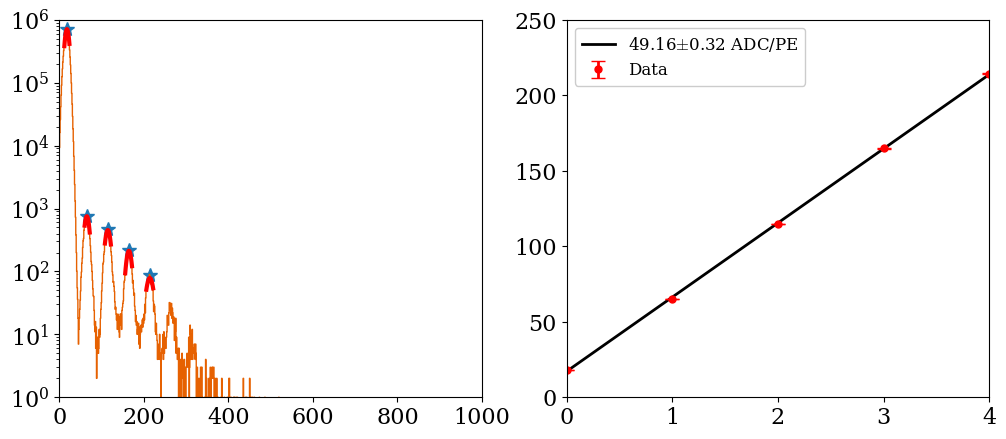

1 /Users/tizi/Documents/YALE_WL.nosync/data/20220609/mca_keith_2.50OV.h5
[18.091901865347094, 79.44612798734416, 143.1638485856934, 207.30558538166898, 271.8183397752412]
[61.35422612 63.7177206  64.1417368  64.51275439]
63.43160947747353


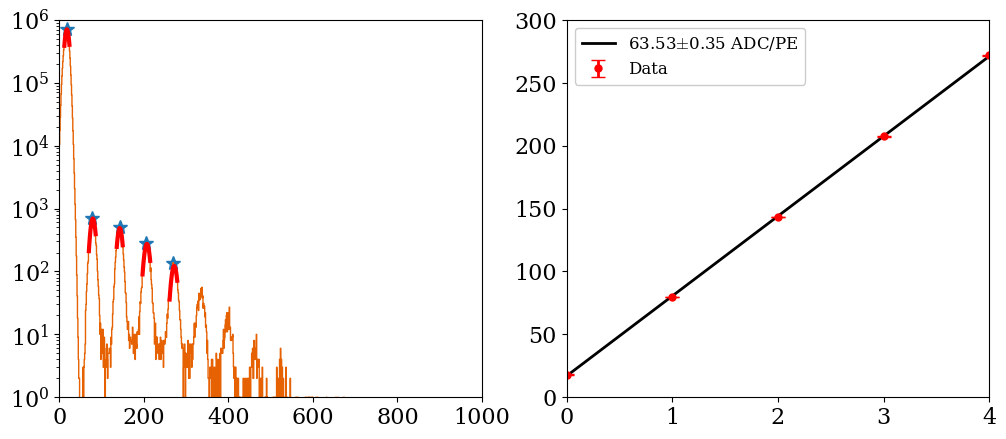

2 /Users/tizi/Documents/YALE_WL.nosync/data/20220609/mca_keith_3.00OV.h5
[17.95716566026973, 93.12677906589465, 171.7625359430762, 250.23401820632353, 328.64474168895134]
[75.16961341 78.63575688 78.47148226 78.41072348]
77.67189400717041


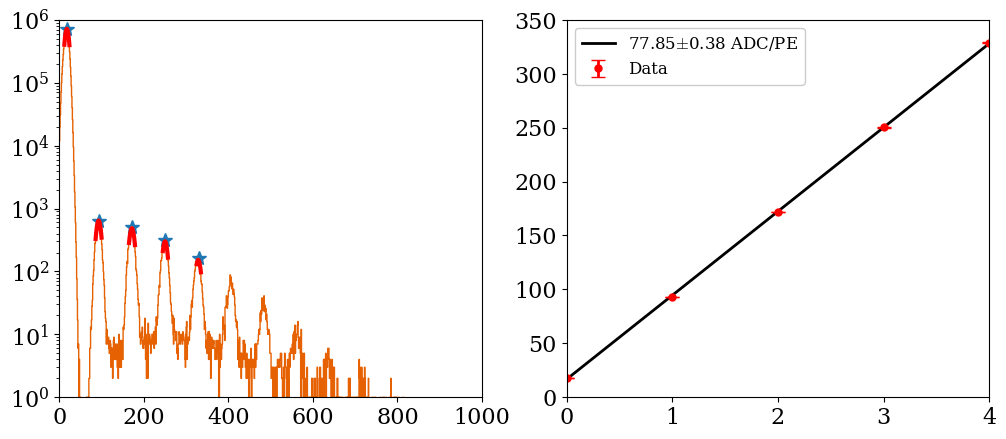

3 /Users/tizi/Documents/YALE_WL.nosync/data/20220609/mca_keith_3.50OV.h5
[17.786009122892093, 107.17730233094353, 199.4464609285234, 291.4212784221778, 383.4404637745696]
[89.39129321 92.2691586  91.97481749 92.01918535]
91.41361366291937


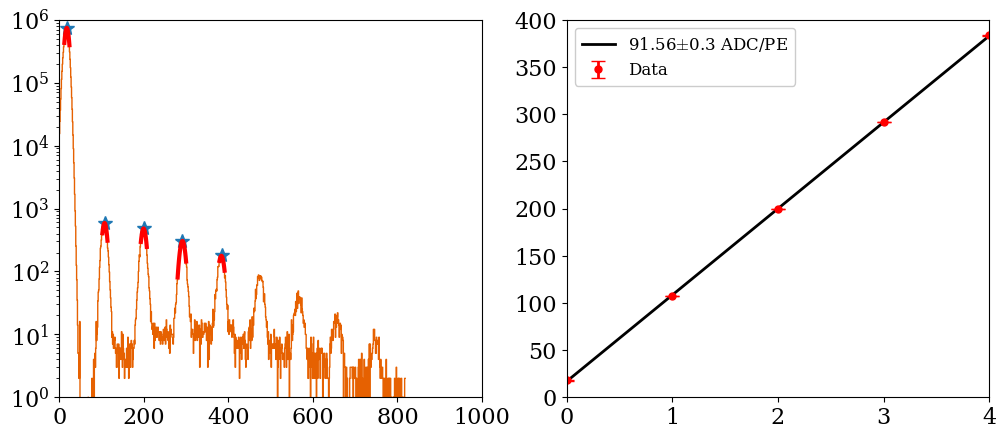

4 /Users/tizi/Documents/YALE_WL.nosync/data/20220609/mca_keith_4.00OV.h5
[17.62951207995535, 120.70738594225804, 226.71735888784892, 332.41297908769076, 438.2929322399371]
[103.07787386 106.00997295 105.6956202  105.87995315]
105.16585503999545


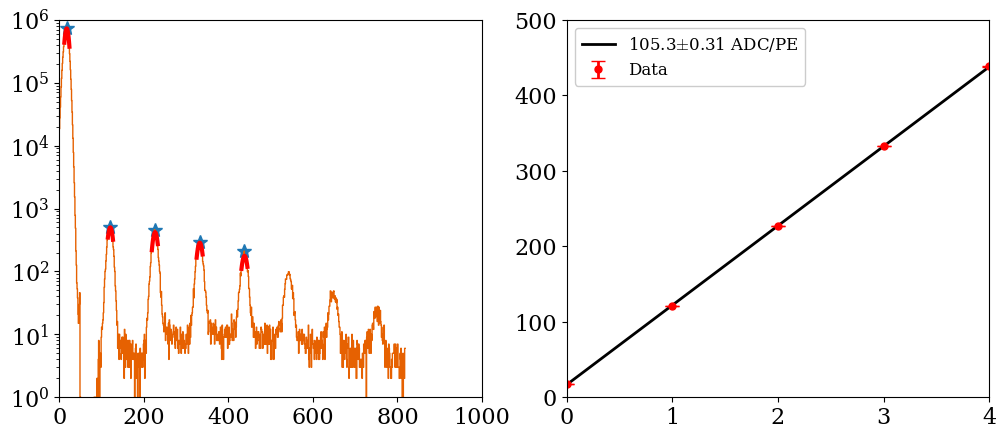

5 /Users/tizi/Documents/YALE_WL.nosync/data/20220609/mca_keith_4.50OV.h5
[17.527810375749127, 134.0514204792527, 253.8594548729966, 372.9787559651682, 491.8090987059302]
[116.5236101  119.80803439 119.11930109 118.83034274]
118.57032208254526


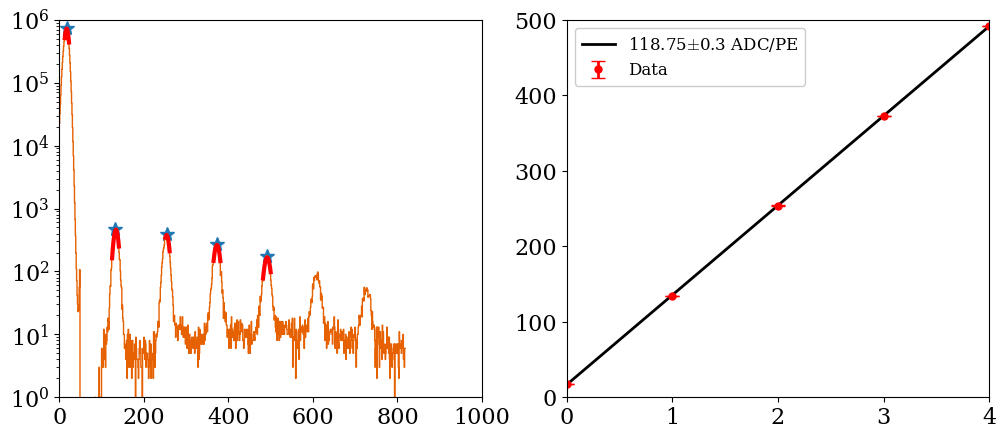

6 /Users/tizi/Documents/YALE_WL.nosync/data/20220609/mca_keith_5.00OV.h5
[17.337380246926813, 147.13949404013437, 279.66450920232995, 411.56015449133, 543.3892930197694]
[129.80211379 132.52501516 131.89564529 131.82913853]
131.51297819321064


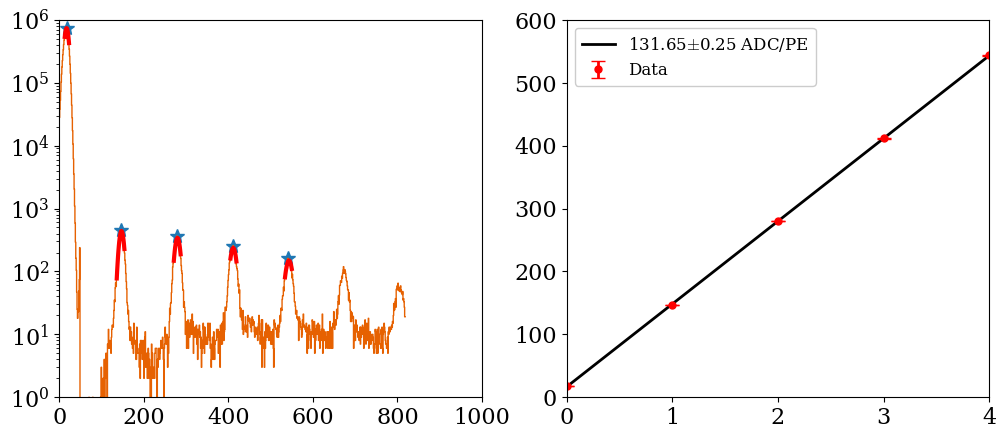

7 /Users/tizi/Documents/YALE_WL.nosync/data/20220609/mca_keith_5.50OV.h5
[17.073762992464708, 159.9878087537576, 304.8881367891229, 450.121126996276, 594.1774029367501]
[142.91404576 144.90032804 145.23299021 144.05627594]
144.27590998607135


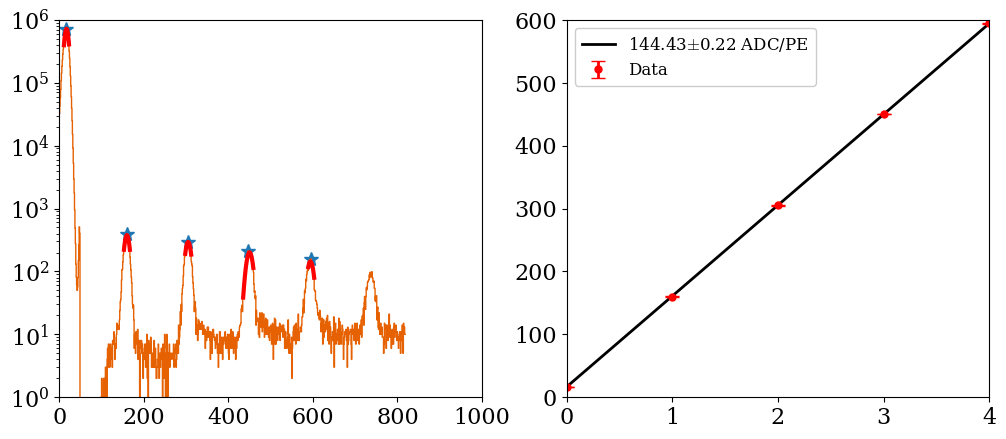

8 /Users/tizi/Documents/YALE_WL.nosync/data/20220609/mca_keith_6.00OV.h5
[16.848782200202866, 171.54109520232595, 329.50343715268974, 486.28006444740305, 642.1906778450114]
[154.692313   157.96234195 156.77662729 155.9106134 ]
156.33547391120214


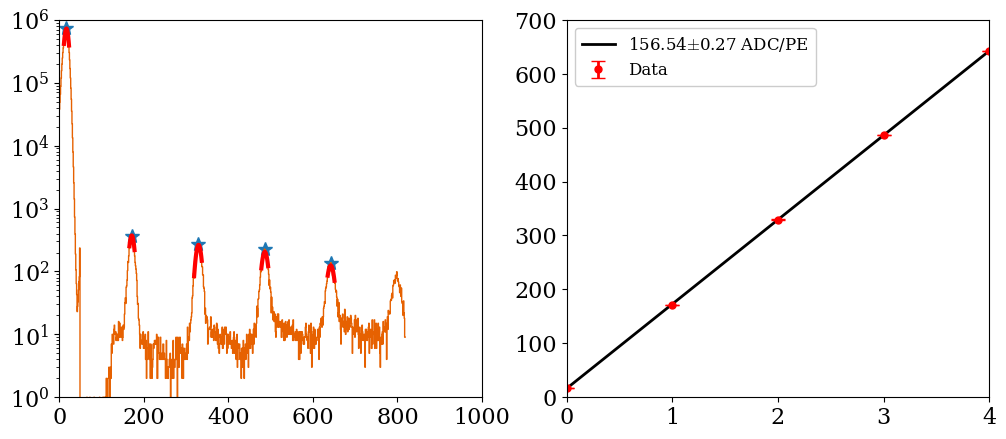

9 /Users/tizi/Documents/YALE_WL.nosync/data/20220609/mca_keith_6.50OV.h5
[16.652570785385752, 183.5969893081587, 352.89376285163996, 521.923516202823, 689.3914166274942]
[166.94441852 169.29677354 169.02975335 167.46790042]
168.18471146052713


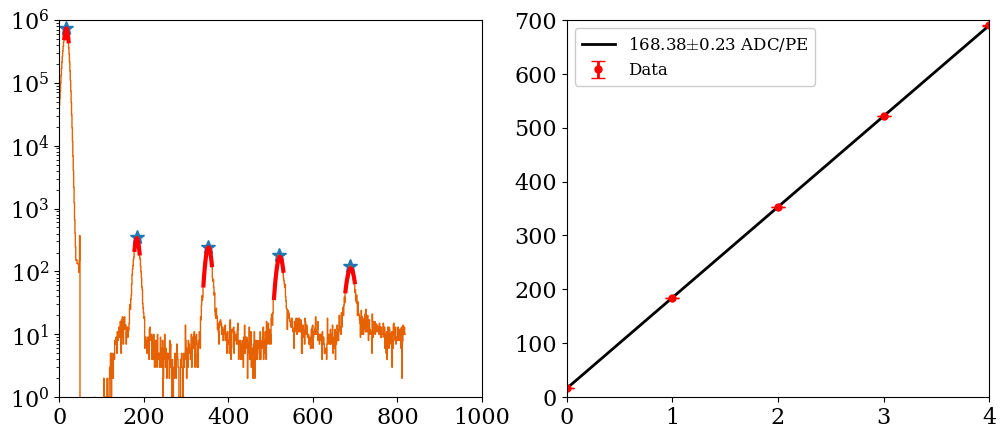

10 /Users/tizi/Documents/YALE_WL.nosync/data/20220609/mca_keith_7.00OV.h5
[16.35577096655004, 195.01968533316872, 375.597686020387, 555.7169082173967, 734.1686572121764]
[178.66391437 180.57800069 180.1192222  178.45174899]
179.4532215614066


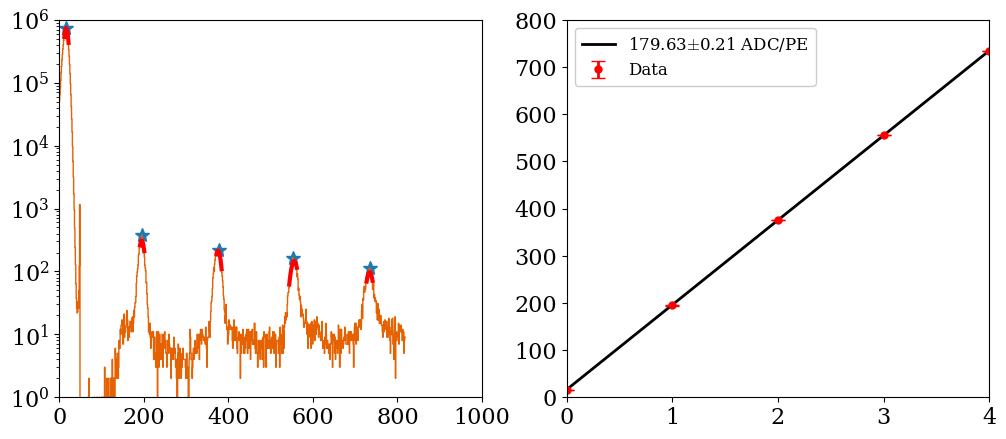

In [ ]:
gain_list_0V,gain_err_0V=gain_calculator(Path)

[31.0V|2e-06]: Gain 70.0 --> !NOTE:  Error is too small --> replacing 0.0 with 1e-08
[31.5V|2e-06]: Gain 80.00000000000001 --> !NOTE:  Error is too small --> replacing 1.797546735914701e-14 with 1e-08
[32.0V|2e-06]: Gain 90.00000000000001 --> !NOTE:  Error is too small --> replacing 1.797546735915192e-14 with 1e-08
[32.5V|2e-06]: Gain 98.0, Err 0.7071067811882156 added to the array
[33.0V|2e-06]: Gain 104.50000000000001, Err 1.3228756555355718 added to the array
[33.5V|2e-06]: Gain 115.00000000000003, Err 1.5811388300883744 added to the array
[34.0V|2e-06]: Gain 123.50000000007306, Err 0.8660254037868367 added to the array
[34.5V|2e-06]: Gain 131.50000000009052, Err 0.866025403786919 added to the array
[31.0V|5e-06]: Gain 73.49999999996399, Err 0.8660254037858988 added to the array
[31.5V|5e-06]: Gain 83.49999999998579, Err 0.8660254037861804 added to the array
[32.0V|5e-06]: Gain 93.50000000000762, Err 0.8660254037863997 added to the array
[32.5V|5e-06]: Gain 102.0, Err 0.707106781188

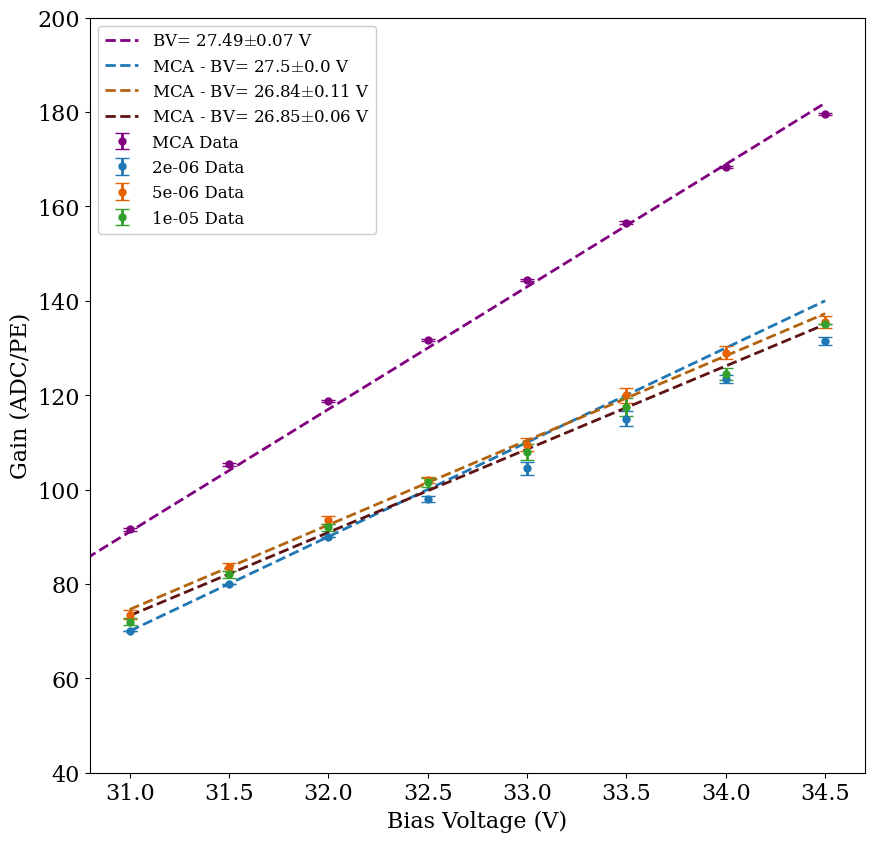

In [ ]:
def line(x,a,b):
    return a*(x-b)
plt.figure(figsize=(10,10))
volts = voltages.astype(float) + 27.5
x_data=np.arange(np.min(volts),np.max(volts)+0.1,1)
plt.errorbar(volts,gain_list_0V,yerr=gain_err_0V,label='MCA Data',fmt='o',ms=5,color='purple')

popt_0,pcov_0=curve_fit(line,volts,gain_list_0V,p0=[31,27],sigma=gain_err_0V)
label = 'BV= '+str(np.round(popt_0[1],2))+ '$\pm$'+ str(np.round(np.sqrt(np.diag(pcov_0)[1]),2))+' V'
plt.plot(x_data, line(x_data,*popt_0), color='purple', ls='--', label=label)
# plt.plot(x_data,line(x_data,*popt_260),color=colors[1],label='BV= '+str(np.round(popt_260[1],2))+ '$\pm$'+ str(np.round(np.sqrt(np.diag(pcov_260)[1]),2))+' V',ls='--')

summarized_data = {}
#plt.figure(figsize=(10,10))
for ii, sh_time in enumerate(peaks.keys()):

    #print(peaks[sh_time])

    gain_temp = []
    err_temp = []
    for volt in peaks[sh_time].keys():
        opt = float(peaks[sh_time][volt]['popt'])
        err = peaks[sh_time][volt]['perr']
        if err < 1e-08:
            err = 1e-08
            print(f'{ANSI_CYAN}[{float(volt)+27.5}V|{sh_time}]:{ANSI_YELLOW} Gain {opt} --> !NOTE:  Error is too small --> replacing {peaks[sh_time][volt]["perr"]} with {err}{ANSI_RESET}') 
        else: print(f'{ANSI_CYAN}[{float(volt)+27.5}V|{sh_time}]:{ANSI_RESET} Gain {opt}, Err {err} added to the array{ANSI_RESET}')        

        gain_temp.append(opt)
        err_temp.append(err)

    volts = [float(x) + 27.5 for x in np.array([*peaks[sh_time].keys()])]
    x_data=np.arange(np.min(volts),np.max(volts)+0.1,0.5)
    plt.xlim(np.min(volts)-0.2,np.max(volts)+0.2)

    plt.errorbar(volts,gain_temp,yerr=err_temp,label=str(sh_time)+' Data',fmt='o',ms=5,color=colors[ii])
    popt_0,pcov_0=curve_fit(line,x_data,gain_temp,p0=[31,27],sigma=err_temp)
    if pcov_0[0][0] == np.inf: print(f'{ANSI_RED} ---- COVARIANCE ERROR ---- {ANSI_RESET}')
    label = 'MCA - BV= '+str(np.round(popt_0[1],2))+ '$\pm$'+ str(np.round(np.sqrt(np.diag(pcov_0)[1]),2))+' V'
    plt.plot(x_data, line(volts,*popt_0), color=colors[-ii], ls='--', label=label)
    # plt.plot(x_data,line(x_data,*popt_260),color=colors[1],label='BV= '+str(np.round(popt_260[1],2))+ '$\pm$'+ str(np.round(np.sqrt(np.diag(pcov_260)[1]),2))+' V',ls='--')
    plt.legend(loc=2)
    plt.ylabel('Gain (ADC/PE)')
    plt.xlabel('Bias Voltage (V)')
    #plt.title(f'Shaping time: {sh_time}')
    #plt.show()

plt.show()

In [ ]:
print (voltages)

['2.00' '2.50' '3.00' '3.50' '4.00' '4.50' '5.00' '5.50' '6.00' '6.50'
 '7.00']


[31.0V|2e-06]: Gain 70.0 --> !NOTE:  Error is too small --> replacing 0.0 with 1e-08
[31.5V|2e-06]: Gain 80.00000000000001 --> !NOTE:  Error is too small --> replacing 1.797546735914701e-14 with 1e-08
[32.0V|2e-06]: Gain 90.00000000000001 --> !NOTE:  Error is too small --> replacing 1.797546735915192e-14 with 1e-08
[32.5V|2e-06]: Gain 98.0, Err 0.7071067811882156 added to the array
[33.0V|2e-06]: Gain 104.50000000000001, Err 1.3228756555355718 added to the array
[33.5V|2e-06]: Gain 115.00000000000003, Err 1.5811388300883744 added to the array
[34.0V|2e-06]: Gain 123.50000000007306, Err 0.8660254037868367 added to the array
[34.5V|2e-06]: Gain 131.50000000009052, Err 0.866025403786919 added to the array
[31.0V|5e-06]: Gain 73.49999999996399, Err 0.8660254037858988 added to the array
[31.5V|5e-06]: Gain 83.49999999998579, Err 0.8660254037861804 added to the array
[32.0V|5e-06]: Gain 93.50000000000762, Err 0.8660254037863997 added to the array
[32.5V|5e-06]: Gain 102.0, Err 0.707106781188

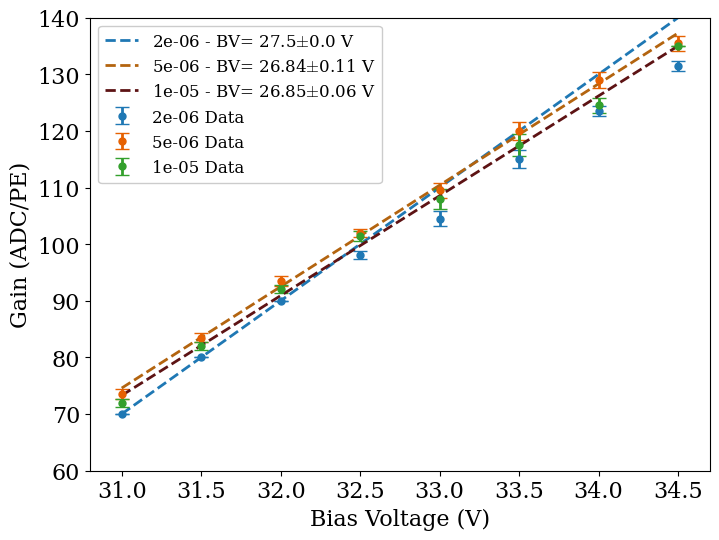